## DS5559 - Project
## Notebook 10 - Sentiment Analysis
### Novel: *Can You Forgive Her* by Anthony Trollope
#### Name: Mengyao Zhang (mz6jv), Runhao Zhao (rz6dg)

# Synopsis

Applying Syuzhet methods to *Can You Forgive Her* by Anthony Trollope using NRC, Bing, Syuzhet.

# Configuration

In [1]:
# Developed in other notebook
lex_db = 'lexicons.db'

# Developed in previous notebooks
text_db = 'project.db'
OHCO = ['book_num','chap_num', 'para_num', 'sent_num', 'token_num']
BOOKS = OHCO[:1] 
CHAPS = OHCO[:2]
PARAS = OHCO[:3]
SENTS = OHCO[:4]

novel_1 = '21' # book_number for "Can You Forgive Her"
 

# emo = 'bing_sentiment'
emo = 'syu_sentiment'

# For KDE
kde_kernel = 'gaussian'
# kde_bandwidth = 100
kde_samples = 1000

# Libraries

In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import sys
import scipy.fftpack as fftpack
from sklearn.neighbors import KernelDensity as KDE
from sklearn.preprocessing import scale

import sqlite3

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import display, HTML

# Pragmas

In [3]:
%matplotlib inline
sns.set()
plt.style.use('fivethirtyeight')

# Process

## Get Lexicons

In [4]:
with sqlite3.connect(lex_db) as db:
    combo = pd.read_sql('SELECT * FROM combo', db, index_col='term_str')

In [5]:
combo.head()

,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,bing_negative,bing_positive,bing_sentiment,syu_sentiment,gi_sentiment
term_str,,,,,,,,,,,,,,,
abandon,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,-0.75,-1.0
abandoned,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,-0.50,NaN
abandoner,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.25,NaN
abandonment,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,-0.25,-1.0
abandons,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.00,NaN


### Get lexicon columns

In [6]:
# emo_cols = [col for col in combo.columns if 'nrc_' in col]
emo_cols = combo.columns

In [7]:
emo_cols

Index(['nrc_anger', 'nrc_anticipation', 'nrc_disgust', 'nrc_fear', 'nrc_joy',
       'nrc_negative', 'nrc_positive', 'nrc_sadness', 'nrc_surprise',
       'nrc_trust', 'bing_negative', 'bing_positive', 'bing_sentiment',
       'syu_sentiment', 'gi_sentiment'],
      dtype='object')

## Analyze Pride and Prejudice 

## Get Text

In [8]:
with sqlite3.connect(text_db) as db:
    tokens = pd.read_sql("SELECT * FROM token WHERE book_num = {} AND punc = 0".format(novel_1), db, index_col=OHCO)
    vocab = pd.read_sql("SELECT * FROM vocab", db, index_col='term_id')

### Merge sentiment lexicon with vocab

In [9]:
tokens = tokens.join(combo, on='term_str', how='left')

In [10]:
tokens

pos    token_str  punc  num  \
book_num chap_num para_num sent_num token_num                                 
21       0        0        0        0            NN  ClassicBook     0    0   
                                    1            CD           21     0    1   
         1        0        0        0            NN      Chapter     0    0   
                                    1           PRP            I     0    0   
                  1        0        0           NNP          Mr.     0    0   
                                    1           NNP      Vavasor     0    0   
                                    2            CC          and     0    0   
                                    3          PRP$          His     0    0   
                                    4            NN     Daughter     0    0   
                  2        0        0           NNP      Whether     0    0   
                                    1            CC           or     0    0   
                                    2            DT           no     0    0   
                                    4           PRP          she     0    0   
                                    6            WP         whom     0    0   
                                    7           PRP          you     0    0   
                                    8           VBP          are     0    0   
                                    9            TO           to     0    0   
                                    10           VB      forgive     0    0   
                                    12           IN           if     0    0   
                                    13          PRP          you     0    0   
                                    14           MD          can     0    0   
                                    16          VBD          did     0    0   
                                    17           CC           or     0    0   
                                    18          VBD          did     0    0   
                                    19           RB          not     0    0   
                                    20           VB       belong     0    0   
                                    21           TO           to     0    0   
                                    22           DT          the     0    0   
                                    23          NNP        Upper     0    0   
                                    24          NNP          Ten     0    0   
...                                             ...          ...   ...  ...   
         81       36       1        9            RB           so     0    0   
                           2        0            CC          But     0    0   
                                    1            IN           as     0    0   
                                    2           PRP         they     0    0   
                                    3           VBP         have     0    0   
                                    4            DT          all     0    0   
                                    5            RB     forgiven     0    0   
                                    6           PRP          her     0    0   
                                    8           VBG    including     0    0   
                                    9            RB         even     0    0   
                                    10          NNP         Lady     0    0   
                                    11          NNP   Midlothian     0    0   
                                    12          PRP      herself     0    0   
                                    14          PRP            I     0    0   
                                    15          VBP         hope     0    0   
                                    16           IN         that     0    0   
                                    17          PRP         they     0    0   
                                    18           WP          who     0    0   
                   

In [11]:
tokens[emo].sample(10)

book_num  chap_num  para_num  sent_num  token_num
21        79        54        1         0             NaN
          49        24        1         3             NaN
          14        11        0         10            NaN
          40        4         5         2             NaN
          27        25        0         18          -0.25
          53        10        0         20            NaN
          39        41        3         30            NaN
          20        18        2         8             NaN
          55        20        16        19            NaN
          57        82        12        10            NaN
Name: syu_sentiment, dtype: float64

In [12]:
tokens[emo_cols] = tokens[emo_cols].fillna(0)

In [13]:
tokens.head(10)

pos    token_str  punc  num  \
book_num chap_num para_num sent_num token_num                                 
21       0        0        0        0            NN  ClassicBook     0    0   
                                    1            CD           21     0    1   
         1        0        0        0            NN      Chapter     0    0   
                                    1           PRP            I     0    0   
                  1        0        0           NNP          Mr.     0    0   
                                    1           NNP      Vavasor     0    0   
                                    2            CC          and     0    0   
                                    3          PRP$          His     0    0   
                                    4            NN     Daughter     0    0   
                  2        0        0           NNP      Whether     0    0   

                                                  term_str  term_id  \
book_num chap_num para_num sent_num token_num                         
21       0        0        0        0          classicbook     6874   
                                    1                 None       -1   
         1        0        0        0              chapter     6192   
                                    1                    i    19667   
                  1        0        0                  mr.    25788   
                                    1              vavasor    42730   
                                    2                  and     1362   
                                    3                  his    18988   
                                    4             daughter     9761   
                  2        0        0              whether    43938   

                                               nrc_anger  nrc_anticipation  \
book_num chap_num para_num sent_num token_num                                
21       0        0        0        0                0.0               0.0   
                                    1                0.0               0.0   
         1        0        0        0                0.0               0.0   
                                    1                0.0               0.0   
                  1        0        0                0.0               0.0   
                                    1                0.0               0.0   
                                    2                0.0               0.0   
                                    3                0.0               0.0   
                                    4                0.0               0.0   
                  2        0        0                0.0               0.0   

                                               nrc_disgust  nrc_fear  \
book_num chap_num para_num sent_num token_num                          
21       0        0        0        0                  0.0       0.0   
                                    1                  0.0       0.0   
         1        0        0        0                  0.0       0.0   
                                    1                  0.0       0.0   
                  1        0        0                  0.0       0.0   
                                    1                  0.0       0.0   
                                    2                  0.0       0.0   
                                    3                  0.0       0.0   
                                    4                  0.0       0.0   
                  2        0        0                  0.0       0.0   

                                                   ...       nrc_negative  \
book_num chap_num para_num sent_num token_num      ...                      
21       0        0        0        0              ...                0.0   
                                    1              ...                0.0   
         1        0        0        0              ...                0.0   
                                    1              ...     

## Sentiment by OHCO

In [14]:
FIG = dict(figsize=(25, 5), legend=True, fontsize=14, rot=45)

### By Chapter

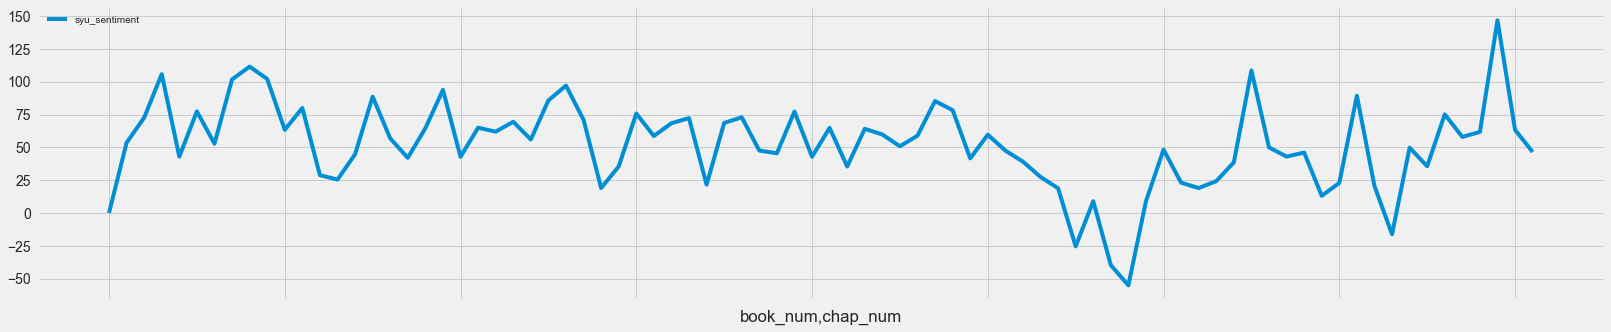

In [15]:
tokens.groupby(CHAPS)[emo].sum().plot(**FIG)

### By Paragraph

In [16]:
by_para = tokens.groupby(PARAS)[emo_cols].sum()

In [17]:
max_x = by_para.shape[0]
xticks = list(range(0, max_x, 100))
xticks.append(max_x - 1)

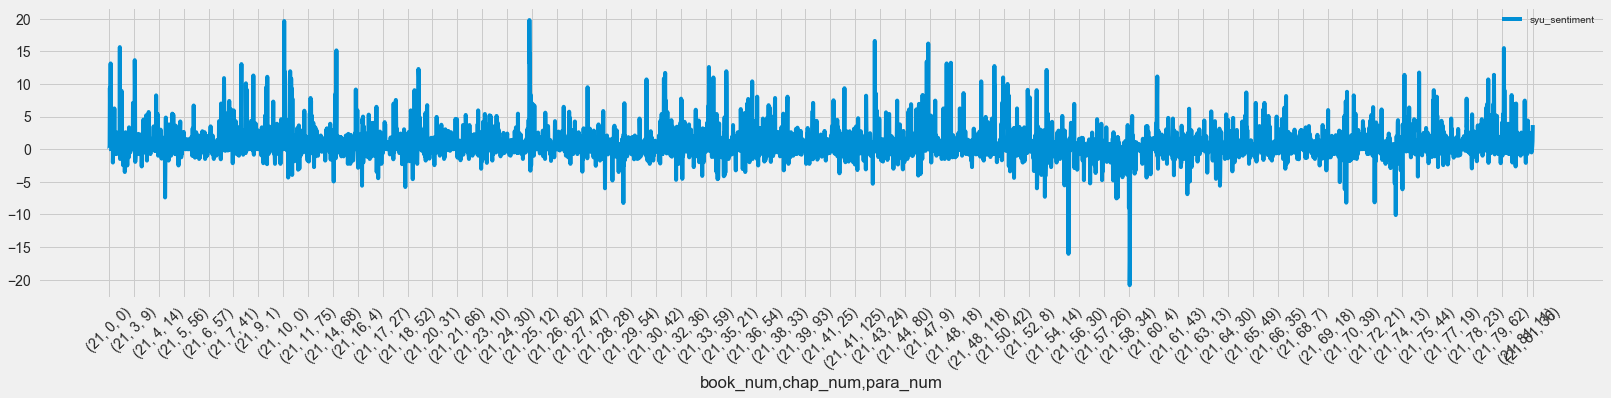

In [18]:
by_para[emo].plot(**FIG, xticks=xticks)

### By Sentence

In [19]:
by_sent = tokens.groupby(SENTS)[emo_cols].sum()

In [20]:
max_x = by_sent.shape[0]
xticks = list(range(0, max_x, 250))
xticks.append(max_x - 1)

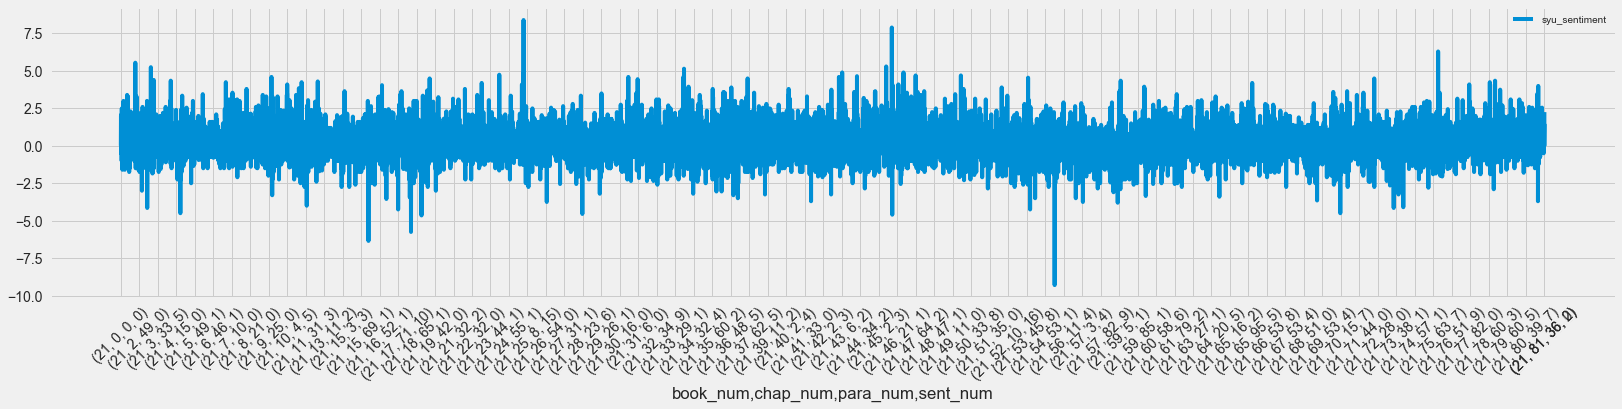

In [21]:
by_sent[emo].plot(**FIG, xticks=xticks)

### Add text to do spot checks

In [22]:
tokens['html'] =  tokens.apply(lambda x: 
                               "<span class='sent{}'>{}</span>".format(int(np.sign(x[emo])), x.token_str), 1)

In [23]:
tokens['html'].head()

book_num  chap_num  para_num  sent_num  token_num
21        0         0         0         0            <span class='sent0'>ClassicBook</span>
                                        1                     <span class='sent0'>21</span>
          1         0         0         0                <span class='sent0'>Chapter</span>
                                        1                      <span class='sent0'>I</span>
                    1         0         0                    <span class='sent0'>Mr.</span>
Name: html, dtype: object

In [24]:
by_sent['sent_str'] = tokens.groupby(SENTS).term_str.apply(lambda x: x.str.cat(sep=' '))
by_sent['html_str'] = tokens.groupby(SENTS).html.apply(lambda x: x.str.cat(sep=' '))

In [25]:
by_sent[['sent_str', 'html_str']].head()

sent_str  \
book_num chap_num para_num sent_num                                                      
21       0        0        0                                               classicbook   
         1        0        0                                                 chapter i   
                  1        0                              mr. vavasor and his daughter   
                  2        0         whether or no she whom you are to forgive if y...   
                           1         by blood she was connected with big people dis...   

                                                                              html_str  
book_num chap_num para_num sent_num                                                     
21       0        0        0         <span class='sent0'>ClassicBook</span> <span c...  
         1        0        0         <span class='sent0'>Chapter</span> <span class...  
                  1        0         <span class='sent0'>Mr.</span> <span class='se...  
                  2        0         <span class='sent0'>Whether</span> <span class...  
                           1         <span class='sent0'>By</span> <span class='sen...

### Histogram

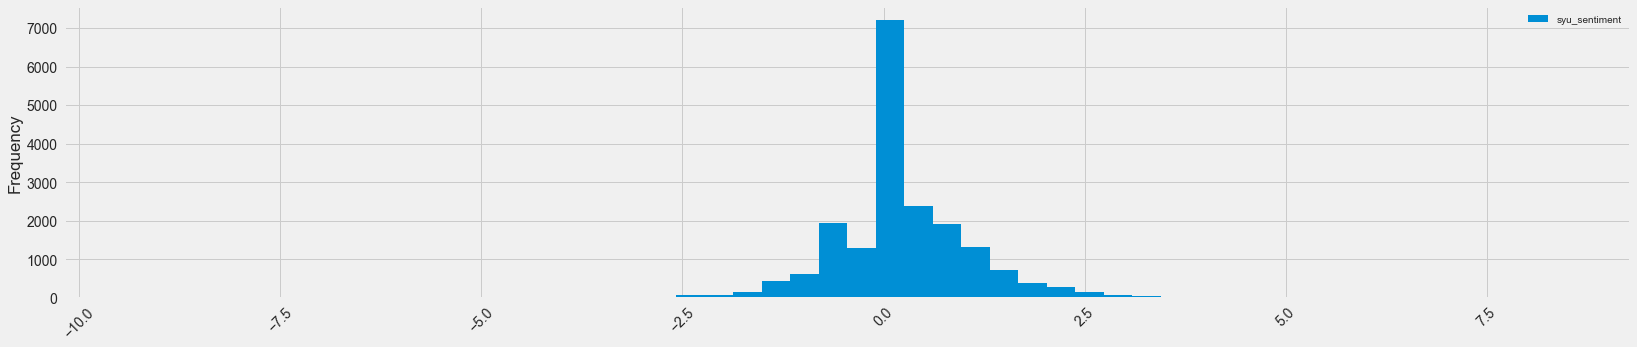

In [26]:
by_sent[emo].plot.hist(**FIG, bins=50)

### Look at a sample of sentences

In [27]:
rows = []
for idx in by_sent.sample(10).index:
    
    valence = round(by_sent.loc[idx, emo], 4)     
    t = 0
    if valence > t: color = '#ccffcc'
    elif valence < t: color = '#ffcccc'
    else: color = '#f2f2f2'
    z=0
    rows.append("""<tr style="background-color:{0};padding:.5rem 1rem;font-size:110%;">
    <td>{1}</td><td>{3}</td><td width="400" style="text-align:left;">{2}</td>
    </tr>""".format(color, valence, by_sent.loc[idx, 'html_str'], idx))
    
display(HTML('<style>#sample1 td{font-size:120%;vertical-align:top;} .sent-1{color:red;font-weight:bold;} .sent1{color:green;font-weight:bold;}</style>'))
display(HTML('<table id="sample1"><tr><th>Sentiment</th><th>ID</th><th width="600">Sentence</th></tr>'+''.join(rows)+'</table>'))

Sentiment,ID,Sentence
0.25,"(21, 62, 5, 1)",Whether any man could really pass an existence of work in such a workshop and not have gone mad could have endured to work there for seven hours a day every week day of his life I am not prepared to say
1.0,"(21, 46, 17, 4)",A Member can do no good at that work till he has learned something of the forms of the House
0.0,"(21, 19, 38, 4)",I need hardly say that I shall not answer it
0.5,"(21, 32, 40, 0)",They walked on exchanging now and again a word or two till the distant Cumberland mountains began to form themselves in groups of beauty before their eyes
2.5,"(21, 44, 48, 5)",She had been a true wife though sometimes too strong minded and a painstaking mother whose children however had never loved her as most mothers like to be loved
-0.25,"(21, 6, 51, 3)",When I think of a chance I ve let go by as I have thousands then it is that I shiver
-0.75,"(21, 3, 42, 2)",I don t know that there has been any delay
2.2,"(21, 25, 2, 10)",He desired to use words for the purpose of teaching things which he knew and which others did not know and he desired also to be honoured for his knowledge
0.0,"(21, 10, 14, 0)",You must not ask me again till the winter shall have passed away
1.0,"(21, 2, 38, 0)",Lady Macleod was a woman of much patience and possessed also of considerable perseverance


### Plot with Xticks

In [28]:
xticks = [0]
xticks += by_sent[emo].reset_index().sort_values(emo).head(7).index.values.tolist()
xticks += by_sent[emo].reset_index().sort_values(emo).tail(7).index.values.tolist()
xticks += [by_sent.shape[0] - 1]

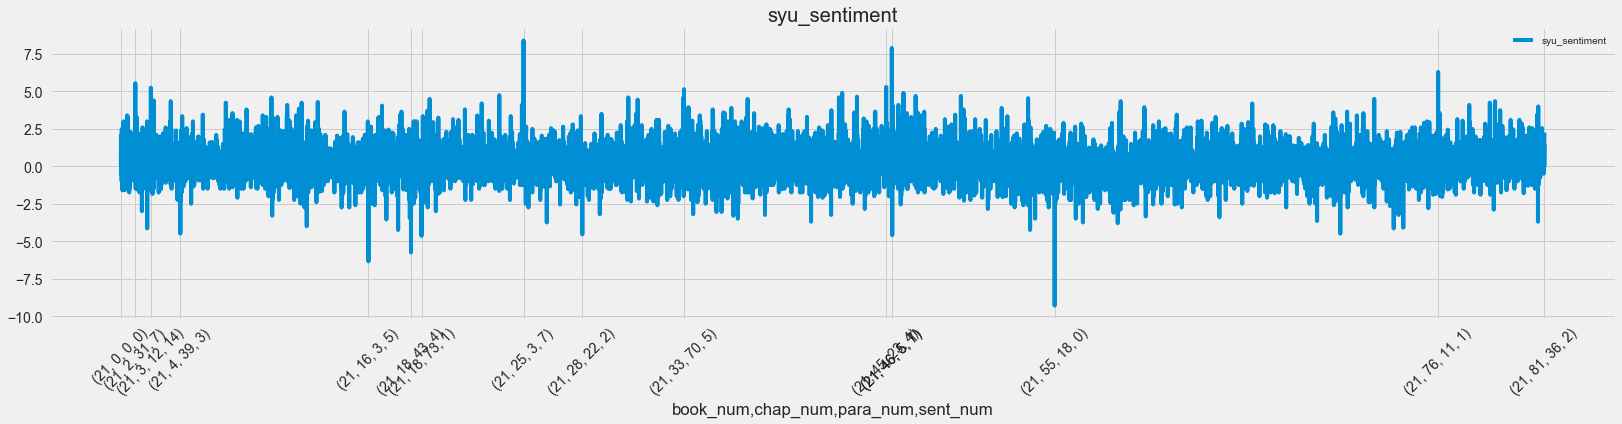

In [29]:
by_sent[emo].plot(**FIG, xticks=xticks, title=emo)

In [30]:
by_sent.iloc[xticks][emo].sort_index().to_frame()

syu_sentiment
book_num chap_num para_num sent_num               
21       0        0        0                  0.00
         2        31       7                  5.55
         3        12       14                 5.25
         4        39       3                 -4.50
         16       3        5                 -6.35
         18       43       4                 -5.75
                  73       1                 -4.65
         25       3        7                  8.40
         28       22       2                 -4.55
         33       70       5                  5.15
         45       23       4                  5.30
         46       5        1                  7.90
                           7                 -4.60
         55       18       0                 -9.30
         76       11       1                  6.30
         81       36       2                  2.25

### Inspect Positives

In [31]:
by_sent.sort_values(emo, ascending=False)[[emo,'sent_str']].head(20)

syu_sentiment  \
book_num chap_num para_num sent_num                  
21       25       3        7                  8.40   
         46       5        1                  7.90   
         76       11       1                  6.30   
         2        31       7                  5.55   
         45       23       4                  5.30   
         3        12       14                 5.25   
         33       70       5                  5.15   
         25       4        2                  4.90   
         47       3        16                 4.90   
         43       7        3                  4.90   
         23       73       7                  4.75   
         47       64       1                  4.70   
         49       46       2                  4.70   
         44       16       1                  4.65   
         30       61       3                  4.60   
         9        33       6                  4.60   
         33       68       3                  4.60   
         43       3        4                  4.60   
         53       47       7                  4.55   
         19       19       3                  4.50   

                                                                              sent_str  
book_num chap_num para_num sent_num                                                     
21       25       3        7         his little threatened mischance a passing fanc...  
         46       5        1         he was a man quite capable of feeling such pri...  
         76       11       1         if i were to hug you with joy and tell you how...  
         2        31       7         mr. grey was a man of high character of good t...  
         45       23       4         in his jovial moods when he was instigating hi...  
         3        12       14        he was noble generous clever good so good as t...  
         33       70       5         a perfect cure i may never expect but i think ...  
         25       4        2         he had been rich before his marriage with his ...  
         47       3        16        when i think that he has forced his way into p...  
         43       7        3         on all these points he was very full and very ...  
         23       73       7         the duchess was a woman of about forty very ha...  
         47       64       1         seeing how very much of a rascal he was alread...  
         49       46       2         so i up and spoke very boldly like the proud y...  
         44       16       1         she had as she herself declared armed herself ...  
         30       61       3         he had learned to comprehend that the world s ...  
         9        33       6         but mrs. greenow was so good natured in tender...  
         33       68       3         we could not stand up together as man and wife...  
         43       3        4         members of parliament and the friends of membe...  
         53       47       7         security for the money advanced by him of cour...  
         19       19       3         i was informed that mr. grey is in every respe...

### Inspect Negatives

In [32]:
by_sent.sort_values(emo, ascending=True)[[emo,'sent_str']].head(20)

syu_sentiment  \
book_num chap_num para_num sent_num                  
21       55       18       0                 -9.30   
         16       3        5                 -6.35   
         18       43       4                 -5.75   
                  73       1                 -4.65   
         46       5        7                 -4.60   
         28       22       2                 -4.55   
         4        39       3                 -4.50   
         70       14       17                -4.50   
         54       2        5                 -4.25   
         17       72       0                 -4.25   
         3        5        9                 -4.15   
         73       31       2                 -4.15   
         74       14       10                -4.10   
         11       35       4                 -4.00   
         58       39       17                -3.80   
         26       59       0                 -3.75   
         57       3        15                -3.75   
         41       62       0                 -3.70   
         81       8        2                 -3.70   
         69       21       4                 -3.65   

                                                                              sent_str  
book_num chap_num para_num sent_num                                                     
21       55       18       0         her cheeks became tinged with shame as she tho...  
         16       3        5         it was a pity that she was such a bore a pity ...  
         18       43       4         but few knew the sad misfortunes which poor po...  
                  73       1         the way was open into the next field a turnip ...  
         46       5        7         he was both mean and vain both a bully and a c...  
         28       22       2         what she had now said struck alice as being vu...  
         4        39       3         on some occasions when he was angry or disappo...  
         70       14       17        except you i have nothing left to me and as re...  
         54       2        5         for years he had been longing that his grandfa...  
         17       72       0         among boys at school the same thing is even mo...  
         3        5        9         were you in danger of meeting paynim foes he n...  
         73       31       2         but his chief object was to avoid any personal...  
         74       14       10        but he was sighing for westminster and regrett...  
         11       35       4         you know as i do that it is a bad fiend and a ...  
         58       39       17        what were the last words upon his impious lips...  
         26       59       0         there is no vulgar error so vulgar that is to ...  
         57       3        15        but he was in truth so sore with anger and dis...  
         41       62       0         you shall be made to pay for this said cheesac...  
         81       8        2         you won t lie awake trembling how on earth you...  
         69       21       4         if i see an hungry woman i can give her my mon...

## Apply Transforms

### Adapt Jockers' revised DCT function

Discrete Cosine Transform. A DCT is a Fourier-related transform similar to the discrete Fourier transform (DFT), but using only real numbers. 

In [33]:
def get_dct_transform(raw_values, low_pass_size = 5, x_reverse_len = 100):
    if low_pass_size > len(raw_values):
        raise ValueError("low_pass_size must be less than or equal to the length of raw_values input vector")
    values_dct = fftpack.dct(raw_values, type = 2)
    keepers = values_dct[:low_pass_size]
    padded_keepers = list(keepers) + list(np.zeros(x_reverse_len - low_pass_size))
    dct_out = fftpack.idct(padded_keepers)
    return(dct_out)

In [34]:
FFTCFG1 = dict(
    low_pass_size = 5,
    x_reverse_len = 100
)
X1 = get_dct_transform(by_sent[emo].values, **FFTCFG1)

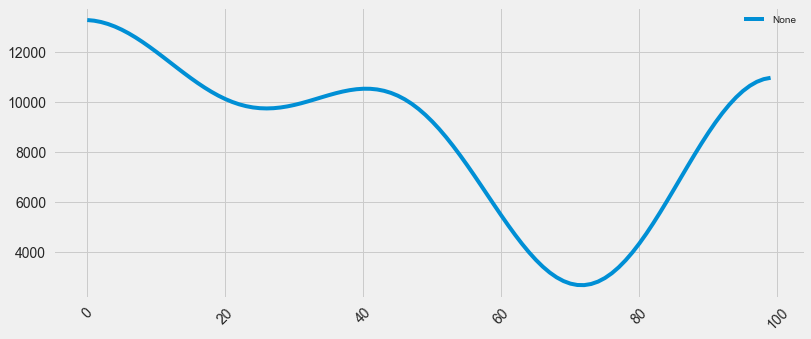

In [35]:
FIG['figsize'] = (12,5)
pd.Series(X1).plot(**FIG)

### Using Rolling
**Window types**: 
boxcar
triang
blackman
hamming
bartlett
parzen
bohman
blackmanharris
nuttall
barthann
kaiser (needs beta)
gaussian (needs std)
general_gaussian (needs power, width)
slepian (needs width).

In [36]:
by_sent.shape

(19253, 17)

In [37]:
# Config for sentences, change window size to 1000
CFG1 = dict(
    win_type='blackman',
    window=1000,
    center=True
)

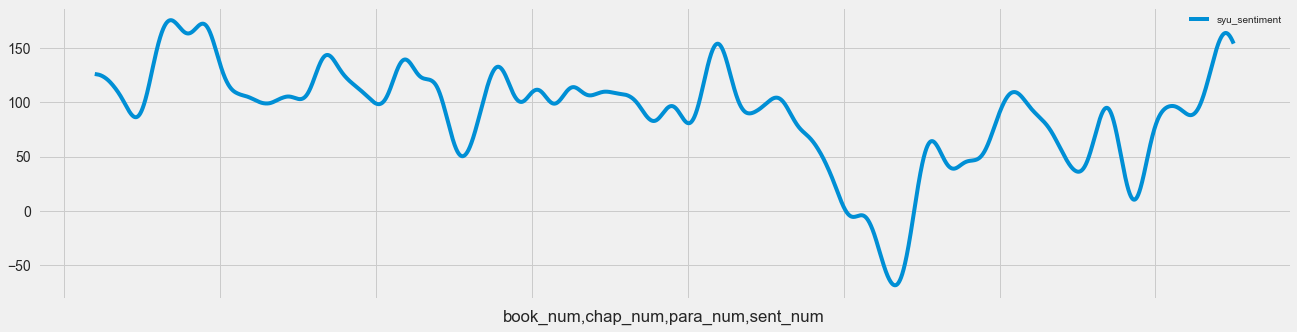

In [38]:
FIG['figsize'] = (20,5)
by_sent[emo].fillna(0).rolling(**CFG1).sum().plot(**FIG)

In [39]:
# Config for tokens
CFG2 = dict(
    win_type='blackman',
    window= int(tokens.shape[0]/ 10),
    center=True
)
CFG2['window']

32250

In [40]:
tokens.shape

(322501, 22)

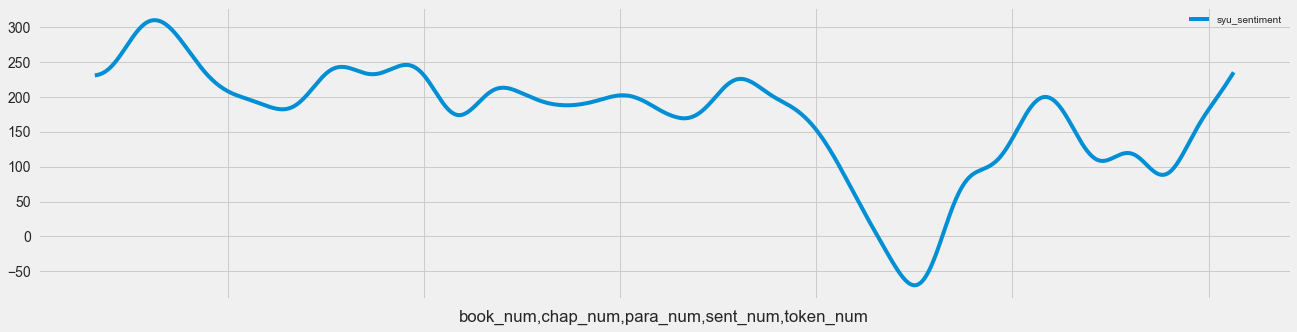

In [41]:
tokens[emo].fillna(0).rolling(**CFG2).sum().plot(**FIG)

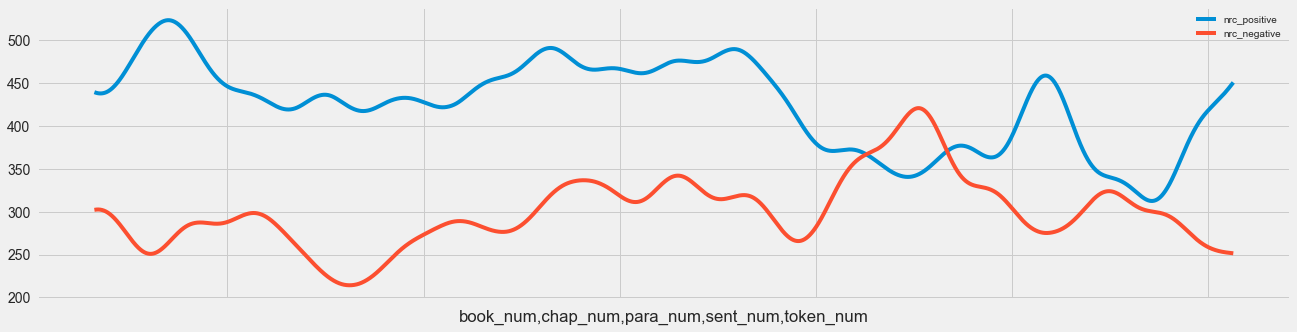

In [42]:
tokens[['nrc_positive','nrc_negative']].rolling(**CFG2).sum().plot(**FIG) 
plt.legend()
# forgive --- positive is higher than negative

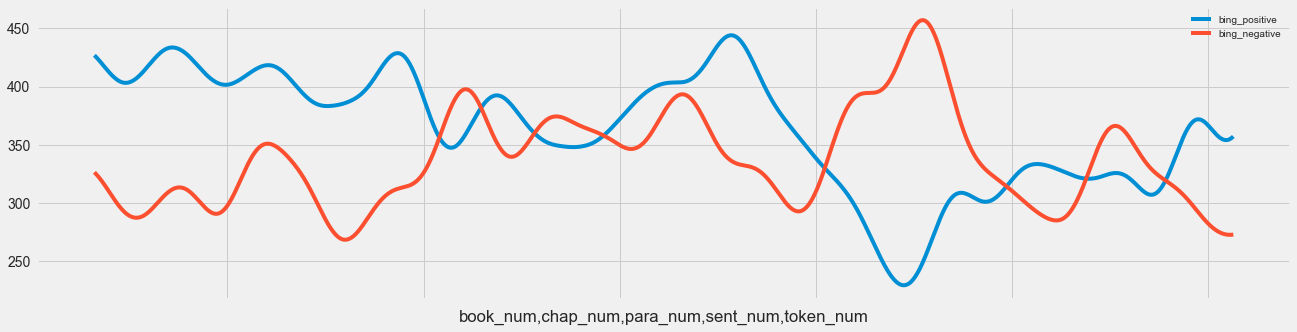

In [43]:
tokens[['bing_positive','bing_negative']].fillna(0).rolling(**CFG2).sum().plot(**FIG)
plt.legend()
# using bing lexicon also gives similar result

## Multinomial Emotions

In [44]:
EOM = tokens[emo_cols].reset_index(drop=True)

In [45]:
EOM.head()

,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,bing_negative,bing_positive,bing_sentiment,syu_sentiment,gi_sentiment
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


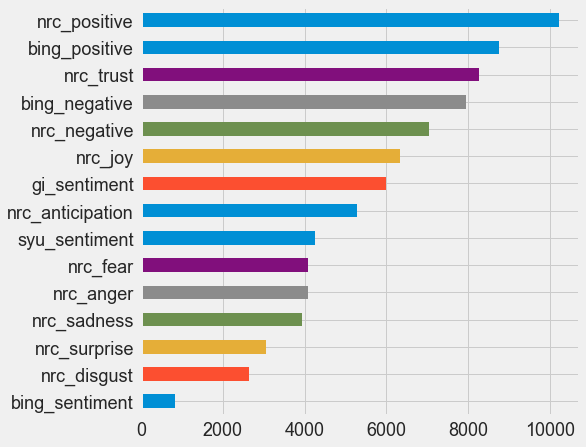

In [46]:
EOM.sum().sort_values().plot.barh(figsize=(7,7), fontsize=18)
# positive - high, disgust - low

### Shape data for Sklearn's KDE function

In [47]:
emo_offsets = []
for col in emo_cols:
    x = EOM[EOM[col] > 0].index.tolist()
    y = [[i] for i in x]
    emo_offsets.append((col, y))
B = pd.DataFrame(emo_offsets, columns=['emo', 'x'])
B = B.set_index('emo')

In [48]:
B

,x
emo,
nrc_anger,"[[144], [183], [302], [373], [418], [421], [45..."
nrc_anticipation,"[[39], [129], [241], [341], [359], [376], [385..."
nrc_disgust,"[[143], [144], [183], [218], [245], [302], [47..."
nrc_fear,"[[144], [183], [241], [302], [376], [430], [47..."
nrc_joy,"[[8], [129], [144], [209], [241], [270], [326]..."
nrc_negative,"[[143], [183], [218], [245], [302], [373], [39..."
nrc_positive,"[[8], [39], [44], [109], [129], [144], [146], ..."
nrc_sadness,"[[144], [183], [397], [430], [564], [687], [73..."
nrc_surprise,"[[341], [418], [421], [435], [479], [566], [63..."


### Get KDE for each emotion

In [49]:
scale_max = EOM.shape[0]
kde_bandwidth = 2500
# kde_bandwidth = 250
x_axis = np.linspace(0, scale_max, kde_samples)[:, np.newaxis]
B['kde'] = B.apply(lambda row: KDE(kernel=kde_kernel, bandwidth=kde_bandwidth).fit(row.x), 1)
B['scores'] = B.apply(lambda row: row.kde.score_samples(x_axis), axis=1)

### Visualize KDE plots

In [50]:
PLOTS = B.apply(lambda row: pd.Series(np.exp(row.scores) * (scale_max / kde_samples)), axis=1).T

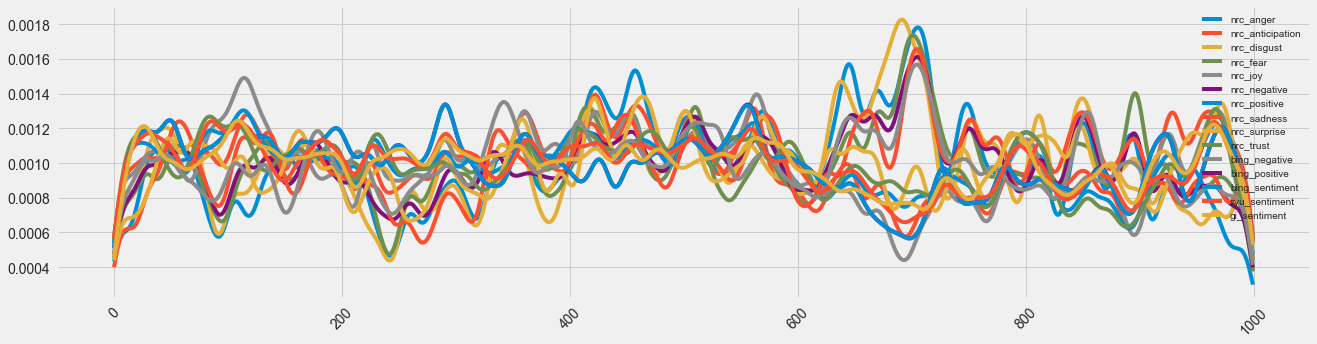

In [51]:
PLOTS.plot(**FIG)
plt.legend()

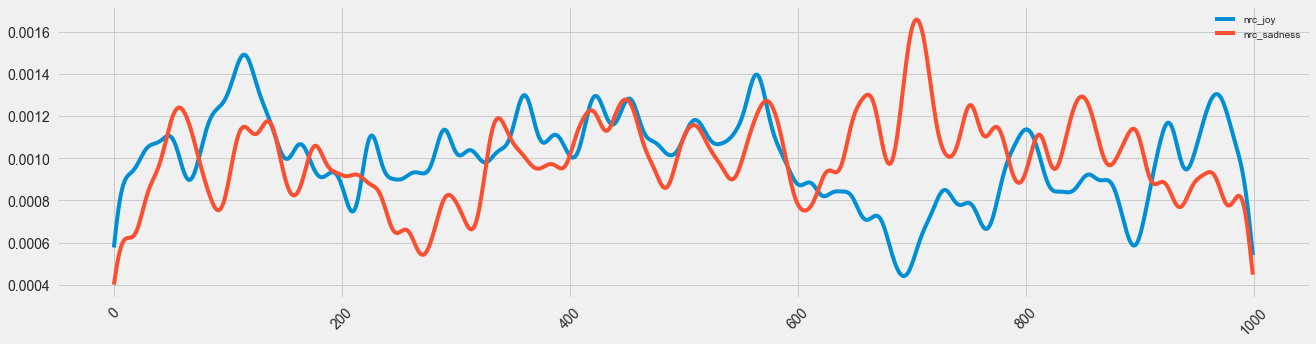

In [52]:
PLOTS[['nrc_joy','nrc_sadness']].plot(**FIG)
plt.legend()

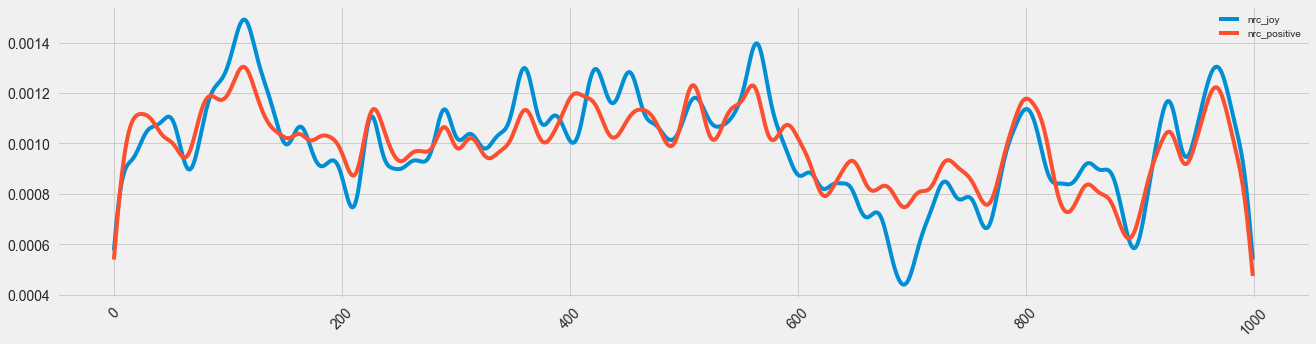

In [53]:
PLOTS[['nrc_joy','nrc_positive']].plot(**FIG)
plt.legend()

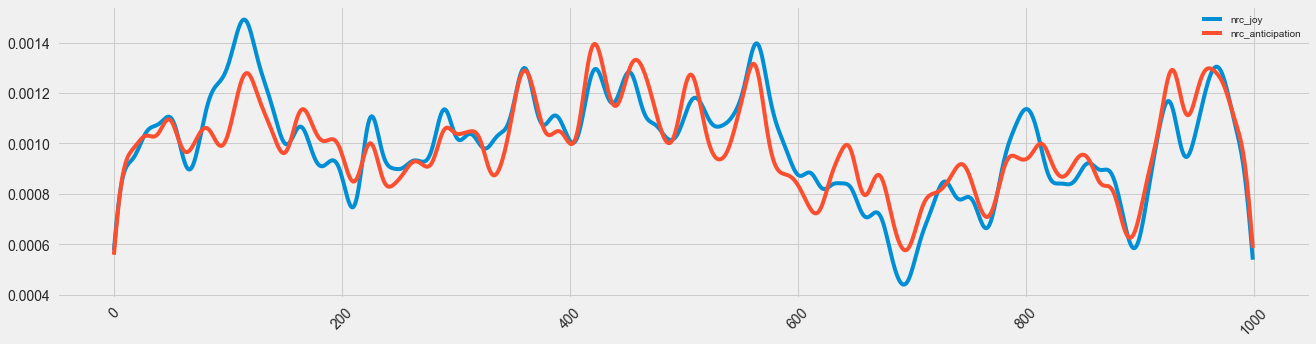

In [54]:
PLOTS[['nrc_joy','nrc_anticipation']].plot(**FIG)
plt.legend()

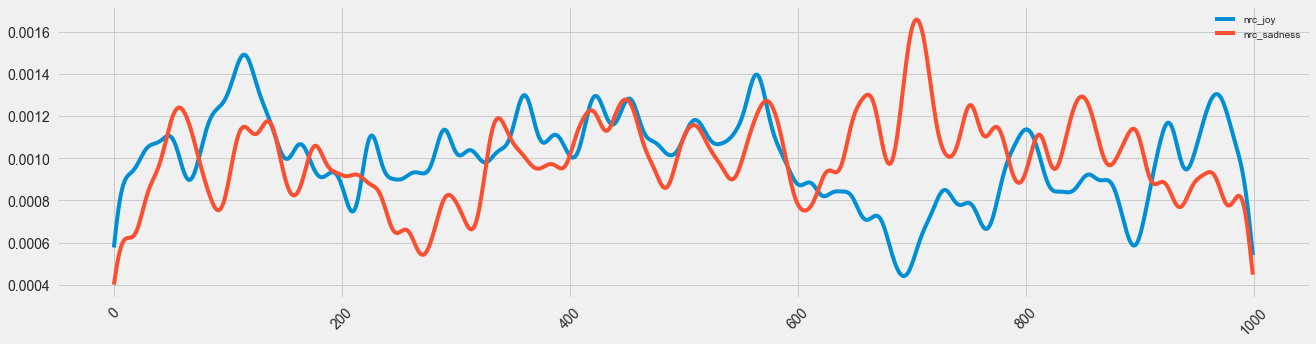

In [55]:
PLOTS[['nrc_joy','nrc_sadness']].plot(**FIG)
plt.legend()

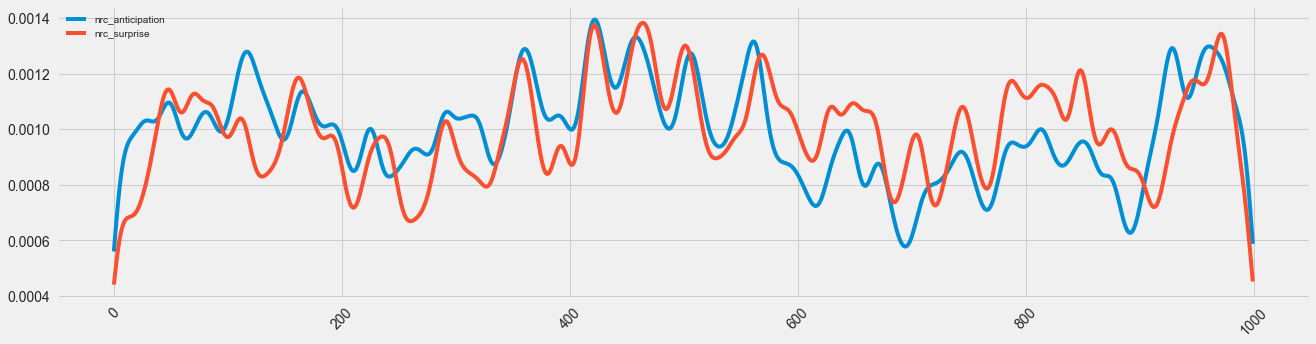

In [56]:
PLOTS[['nrc_anticipation','nrc_surprise']].plot(**FIG)
plt.legend()

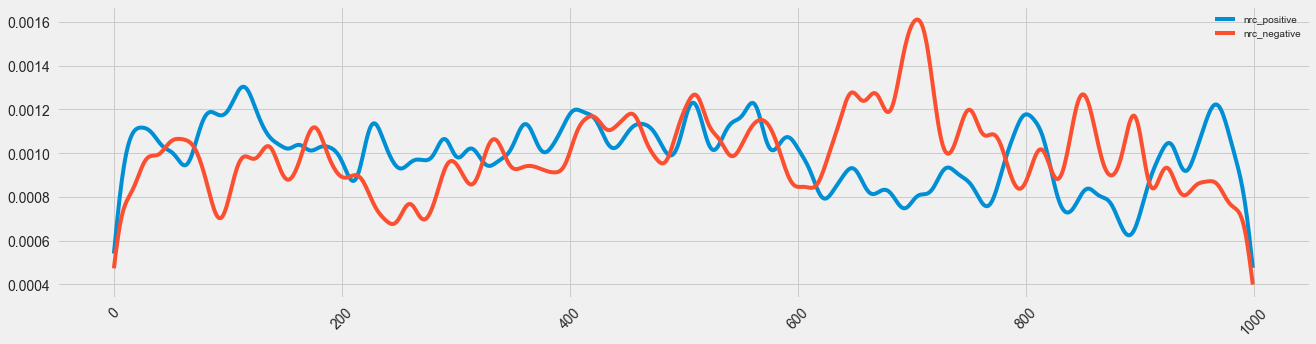

In [57]:
PLOTS[['nrc_positive','nrc_negative']].plot(**FIG)
plt.legend()

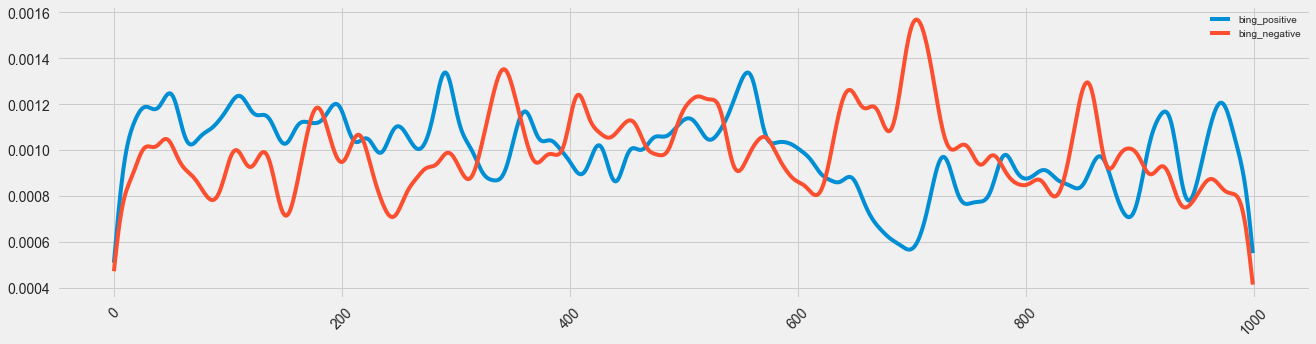

In [58]:
PLOTS[['bing_positive','bing_negative']].plot(**FIG)
plt.legend()

### Compare KDE to Rolling graphs of Sentiment

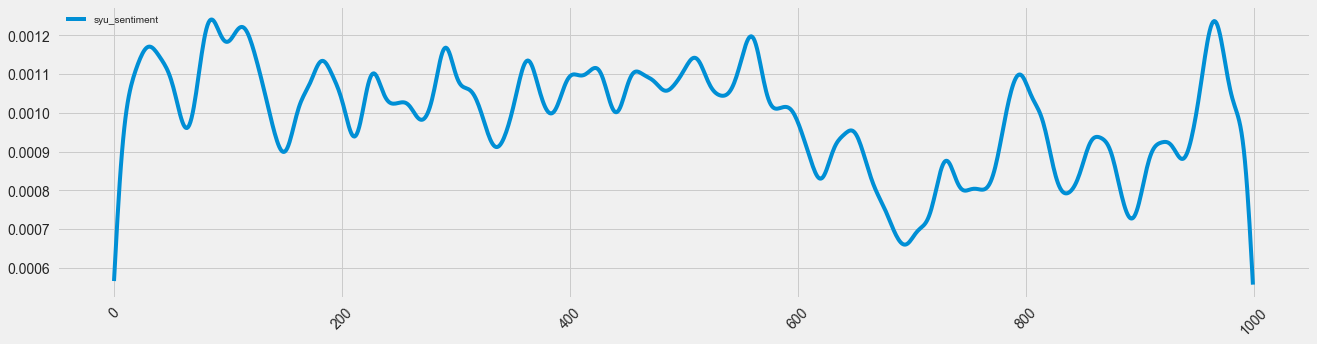

In [59]:
PLOTS[emo].plot(**FIG)

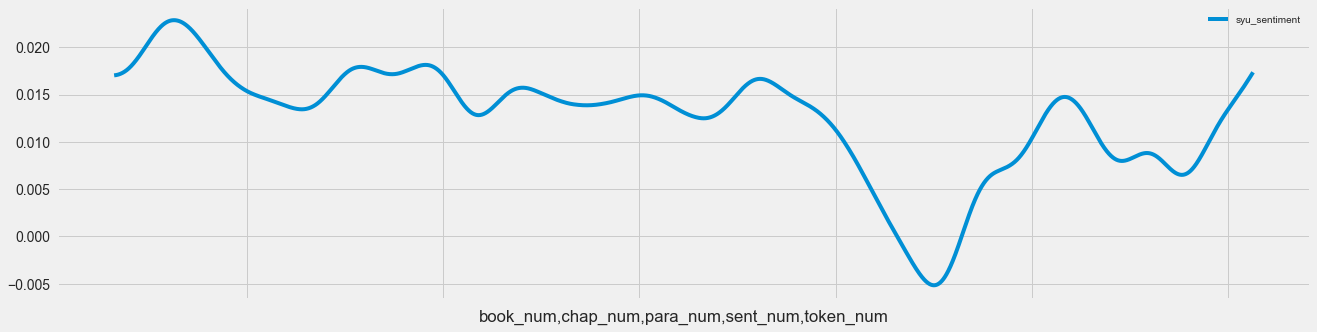

In [60]:
tokens[emo].fillna(0).rolling(**CFG2).mean().plot(**FIG)

## Peak Joy

### Find max joy from PLOTS

In [61]:
PLOTS.head()

emo,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,bing_negative,bing_positive,bing_sentiment,syu_sentiment,gi_sentiment
0,0.000433,0.000559,0.000574,0.000453,0.000576,0.000473,0.000540,0.000400,0.000440,0.000561,0.000472,0.000509,0.000509,0.000566,0.000461
1,0.000465,0.000611,0.000619,0.000496,0.000627,0.000516,0.000594,0.000437,0.000478,0.000616,0.000518,0.000564,0.000564,0.000621,0.000512
2,0.000495,0.000661,0.000661,0.000538,0.000675,0.000557,0.000647,0.000471,0.000515,0.000671,0.000563,0.000620,0.000620,0.000674,0.000563
3,0.000520,0.000707,0.000699,0.000577,0.000719,0.000595,0.000698,0.000502,0.000548,0.000725,0.000606,0.000674,0.000674,0.000726,0.000613
4,0.000542,0.000750,0.000732,0.000613,0.000759,0.000631,0.000747,0.000530,0.000577,0.000776,0.000645,0.000726,0.000727,0.000774,0.000662


In [62]:
PEAK_JOY = int((PLOTS['nrc_joy'].idxmax() / 1000) * tokens.shape[0])

In [63]:
PEAK_JOY_CHAP_NUM = tokens.iloc[PEAK_JOY].name[1]

In [64]:
PEAK_JOY_CHAP_NUM  # the chapter where peak joy appeared

9

### Display Chapter

In [65]:
PEAK_JOY_CHAP = tokens.reset_index()[tokens.reset_index().chap_num==PEAK_JOY_CHAP_NUM].groupby(['para_num']).token_str.apply(lambda x: ' '.join(x)).tolist()

In [66]:
display(HTML('<br/><br/>'.join(PEAK_JOY_CHAP)))

## Experimental Plotting Function

In [67]:
def  plot_sentiment(emo_col, type='sent'):
    if type == 'sent':
        by_sent[emo_col].fillna(0).rolling(**CFG1).mean().plot(**FIG)
    elif type == 'tokens':
        tokens[emo_col].fillna(0).rolling(**CFG2).mean().plot(**FIG)
    elif type == 'kde':
        PLOTS[emo_col].plot(**FIG)
    else:
        pass

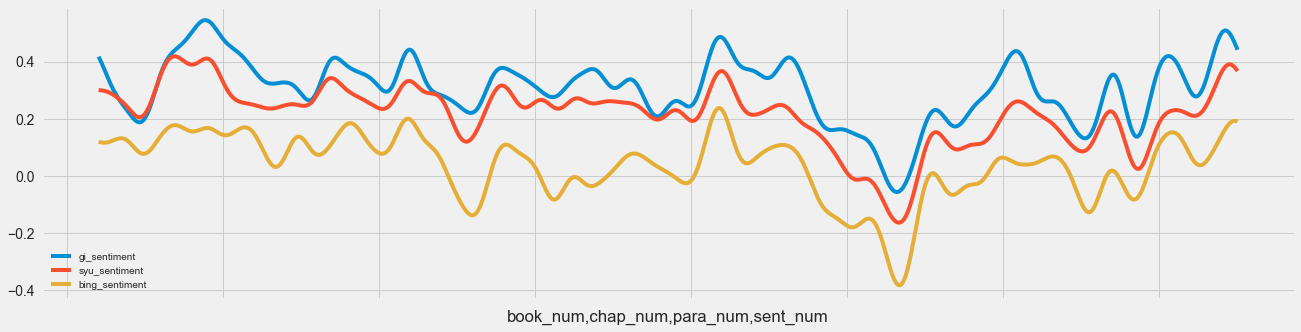

In [68]:
plot_sentiment('gi_sentiment')
plot_sentiment('syu_sentiment')
plot_sentiment('bing_sentiment')

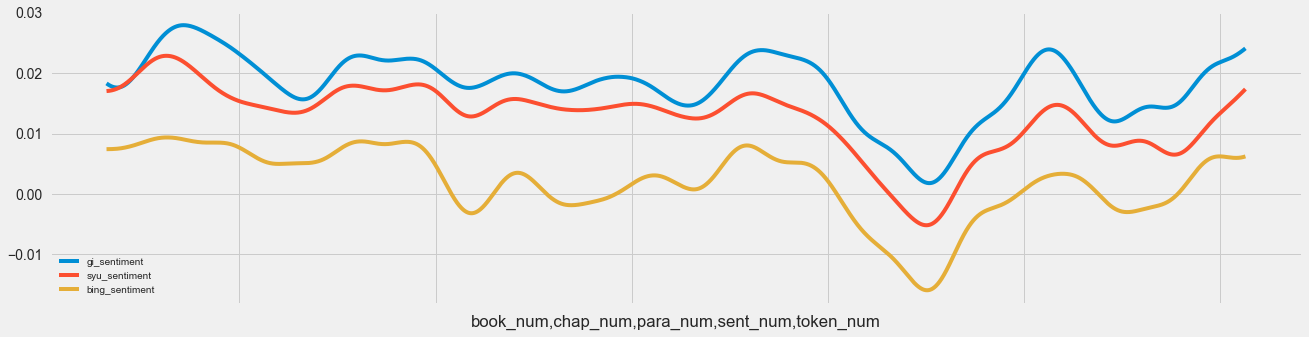

In [69]:
plot_sentiment('gi_sentiment', type='tokens')
plot_sentiment('syu_sentiment', type='tokens')
plot_sentiment('bing_sentiment', type='tokens')

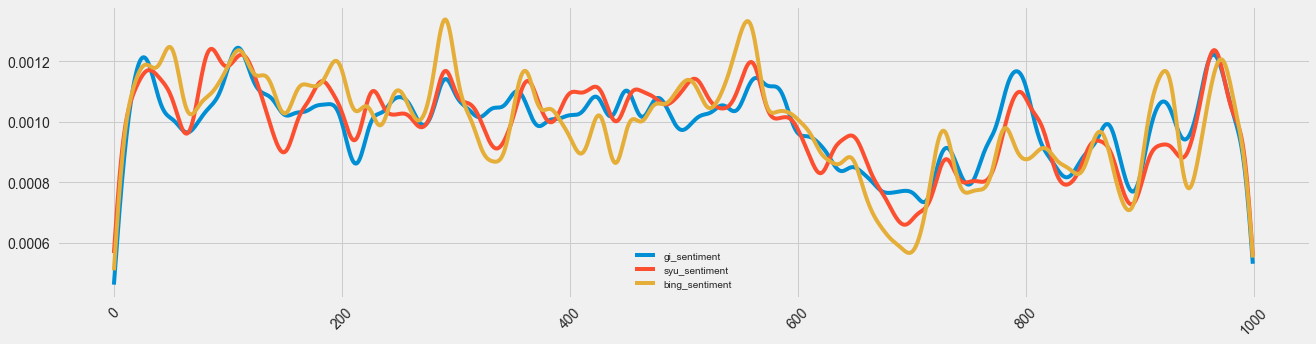

In [70]:
plot_sentiment('gi_sentiment', type='kde')
plot_sentiment('syu_sentiment', type='kde')
plot_sentiment('bing_sentiment', type='kde')

In [71]:
# End